# Lab-10-4-1 ImageFolder1


In [1]:
!git clone https://github.com/deeplearningzerotoall/PyTorch

Cloning into 'PyTorch'...
remote: Enumerating objects: 1899, done.
remote: Total 1899 (delta 0), reused 0 (delta 0), pack-reused 1899
Receiving objects: 100% (1899/1899), 80.33 MiB | 22.64 MiB/s, done.
Resolving deltas: 100% (242/242), done.


In [2]:
import torchvision
import torch
from torchvision import transforms

from torch.utils.data import DataLoader
from matplotlib.pyplot import imshow

In [3]:
%matplotlib inline

In [4]:
trans = transforms.Compose([
     transforms.Resize((64, 128))                       
])

train_data = torchvision.datasets.ImageFolder(root = 'PyTorch/custom_data/origin_data',
                                              transform = trans)


data size is 512 x 256 : so Big

In [5]:
for num, value in enumerate(train_data):
  data, label = value
  print(num, data, label)

  if(label == 0):
    data.save('PyTorch/custom_data/origin_data/gray/%d_%d.jpeg'%(num,label))
  else:
    data.save('PyTorch/custom_data/origin_data/red/%d_%d.jpeg'%(num, label))

0 <PIL.Image.Image image mode=RGB size=128x64 at 0x7F1F70328210> 0
1 <PIL.Image.Image image mode=RGB size=128x64 at 0x7F1F7031A710> 0
2 <PIL.Image.Image image mode=RGB size=128x64 at 0x7F1F70AD8650> 0
3 <PIL.Image.Image image mode=RGB size=128x64 at 0x7F1F7031A890> 0
4 <PIL.Image.Image image mode=RGB size=128x64 at 0x7F1F7031AB50> 0
5 <PIL.Image.Image image mode=RGB size=128x64 at 0x7F1F7031AC10> 0
6 <PIL.Image.Image image mode=RGB size=128x64 at 0x7F1F7031ABD0> 0
7 <PIL.Image.Image image mode=RGB size=128x64 at 0x7F1F7031AD90> 0
8 <PIL.Image.Image image mode=RGB size=128x64 at 0x7F1F7031AC50> 0
9 <PIL.Image.Image image mode=RGB size=128x64 at 0x7F1F7031AA50> 0
10 <PIL.Image.Image image mode=RGB size=128x64 at 0x7F1F7031AE10> 0
11 <PIL.Image.Image image mode=RGB size=128x64 at 0x7F1F7031AAD0> 0
12 <PIL.Image.Image image mode=RGB size=128x64 at 0x7F1F7031A8D0> 0
13 <PIL.Image.Image image mode=RGB size=128x64 at 0x7F1F7031A950> 0
14 <PIL.Image.Image image mode=RGB size=128x64 at 0x7F1F70

data shape : 3 x 64 x 128

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)


In [8]:
trans = transforms.Compose([
                            transforms.ToTensor()
])

train_data = torchvision.datasets.ImageFolder(root = 'PyTorch/custom_data/train_data', transform = trans)


In [9]:
data_loader = DataLoader(dataset = train_data, batch_size = 8, shuffle = True, num_workers = 2)

In [10]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 6, 5),   # default of stride = 1, padding = 0    / [3, 6, 60, 124]
        nn.ReLU(),  
        nn.MaxPool2d(2)  # [3, 6, 30, 62]
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(6, 16, 5),  # [3, 16, 26, 58]    
        nn.ReLU(),   
        nn.MaxPool2d(2) # [3, 16, 13, 29]
    )

    self.layer3 = nn.Sequential(
        nn.Linear(16*13*29, 120),
        nn.ReLU(),
        nn.Linear(120, 22)
    )
  
  def forward(self, x):
    out = self.layer1(x)
    #print(out.shape)
    out = self.layer2(out)
    #print(out.shape)
    out = out.view(out.shape[0] , -1)
    #print(out.shape)
    out = self.layer3(out)
    return out
    

In [11]:
# testing

net = CNN().to(device)
test_input = (torch.Tensor(3, 3, 64, 128)).to(device)
test_out = net((test_input))
test_out.shape

torch.Size([3, 22])

In [12]:
optimizer = optim.Adam(net.parameters(), lr = 0.00005)
loss_func = nn.CrossEntropyLoss().to(device)


In [13]:
total_batch = len(data_loader)

epochs = 5
for epoch in range(epochs):
  avg_cost = 0
  for num, data in enumerate(data_loader):
    imgs, labels = data
    imgs = imgs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    out = net(imgs)
    loss = loss_func(out, labels)
    loss.backward()
    optimizer.step()

    avg_cost += loss / total_batch

  print('[Epoch: {}] cost = {}'.format(epoch+1, avg_cost))

print('Learning finished')

[Epoch: 1] cost = 1.7277435064315796
[Epoch: 2] cost = 0.59367835521698
[Epoch: 3] cost = 0.4158935248851776
[Epoch: 4] cost = 0.20667481422424316
[Epoch: 5] cost = 0.0909244641661644
Learning finished


In [14]:
import os
os.mkdir("/content/PyTorch/model") 
torch.save(net.state_dict(), "/content/PyTorch/model/model.pth")

In [15]:
new_net = CNN().to(device)

In [16]:
new_net.load_state_dict(torch.load('/content/PyTorch/model/model.pth'))

<All keys matched successfully>

In [17]:
print(net.layer1[0])
print(new_net.layer1[0])

print(net.layer1[0].weight[0][0][0])
print(new_net.layer1[0].weight[0][0][0])

net.layer1[0].weight[0] == new_net.layer1[0].weight[0]

Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
tensor([-0.0872,  0.0074, -0.0129, -0.0169,  0.0976], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([-0.0872,  0.0074, -0.0129, -0.0169,  0.0976], device='cuda:0',
       grad_fn=<SelectBackward>)


tensor([[[True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True]],

        [[True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True]],

        [[True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True]]], device='cuda:0')

In [18]:
trans = torchvision.transforms.Compose([
                                        transforms.Resize((64, 128)),
                                        transforms.ToTensor()
])

test_data = torchvision.datasets.ImageFolder(root = '/content/PyTorch/custom_data/test_data', transform = trans)


In [19]:
test_set = DataLoader(dataset = test_data, batch_size = len(test_data))

In [20]:
with torch.no_grad():
  for num, data in enumerate(test_set):
    imgs, labels = data
    imgs = imgs.to(device)
    labels = labels.to(device)

    prediction = net(imgs)

    correct_prediction = torch.argmax(prediction, 1) == labels

    accuracy = correct_prediction.float().mean()

    print("Accuracy: ", accuracy.item())

Accuracy:  1.0


# Lab-10-5-1 Advnaced CNN(VGG)

In [21]:
import torch.utils.model_zoo as model_zoo

In [22]:
__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]


model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth',
    'vgg13_bn': 'https://download.pytorch.org/models/vgg13_bn-abd245e5.pth',
    'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',
    'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth',
}

In [48]:
class VGG(nn.Module):
  def __init__(self, features, num_classes = 1000, init_weights = True):
    super(VGG, self).__init__()

    self.features = features # convolution layer

    self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

    self.classifier = nn.Sequential(
        nn.Linear(512 * 7 * 7 , 4096),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, num_classes)
    ) # FC layer

    if init_weights:
      self._initialize_weights()

  def forward(self, x):
    x = self.features(x) # Convolution
    x = self.avgpool(x) # avgpool
    x = x.view(x.size(0), -1) 
    x = self.classifier(x) # FC layer
    return x

  def _initialize_weights(self):
    for m in self.modules():  # features가 넘겨준 값을 하나씩 return
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode = 'fan_out', nonlinearity = 'relu')    
          # normalize the convolution layer

        if m.bias is not None:
          nn.init.constant_(m.bias, 0) # in VGG, bias = 0
      
      elif isinstance(m, nn.BatchNorm2d):
        # Normalize
        nn.init.constant_(m.weight, 1)  
        nn.init.constant_(m.bias, 0)
      
      elif isinstance(m, nn.Linear):
        # Normalize
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.constant_(m.bias, 0)
      

In [49]:
def make_layers(cfg, batch_norm = False):
  layers = []
  in_channels = 3

  for v in cfg:
    if v == 'M':
      layers += [nn.MaxPool2d(kernel_size=2, stride=2)]

    else:
      conv2d = nn.Conv2d(in_channels, v, kernel_size = 3, padding = 1)
      if batch_norm:
        layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace = True)]

      else:
        layers += [conv2d, nn.ReLU(inplace = True)]
      in_channels = v

  return nn.Sequential(*layers)

In [50]:
cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], #8 + 3 =11 == vgg11
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], # 10 + 3 = vgg 13
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'], #13 + 3 = vgg 16
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'], # 16 +3 =vgg 19
    'custom' : [64,64,64,'M',128,128,128,'M',256,256,256,'M']
}

In [51]:
conv = make_layers(cfg['custom'], batch_norm = True)

In [52]:
conv

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [53]:
CNN = VGG(make_layers(cfg['custom']), num_classes = 10, init_weights = True)

In [54]:
CNN

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), paddin

# Lab-10-5-2 VGG for cifar10

In [78]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(root = './data', train=True,
                                        download = True, transform = transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = 512,
                                          shuffle= True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root = './data', train=False,
                                        download = True, transform = transform)

testloader = torch.utils.data.DataLoader(testset, batch_size = 4,
                                         shuffle = False, num_workers = 2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


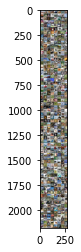

truck   car   dog horse


In [79]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


def imshow(img):
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [80]:
import torchvision.models.vgg as vgg

In [81]:
cfg = [32, 32, 'M', 64, 64, 128, 128, 128, 'M', 256, 256, 256, 512, 512, 512, 'M']

# 32 x 32 => 16 x 16 => 8 x 8 => 4 x 4

In [82]:
class VGG(nn.Module):
  def __init__(self, features, num_classes = 1000, init_weights = True):
    super(VGG, self).__init__()

    self.features = features # convolution layer

    # self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

    self.classifier = nn.Sequential(
        nn.Linear(512 * 4 * 4 , 4096),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, num_classes)
    ) # FC layer

    if init_weights:
      self._initialize_weights()

  def forward(self, x):
    x = self.features(x) # Convolution
    # x = self.avgpool(x) # avgpool
    x = x.view(x.size(0), -1) 
    x = self.classifier(x) # FC layer
    return x

  def _initialize_weights(self):
    for m in self.modules():  # features가 넘겨준 값을 하나씩 return
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode = 'fan_out', nonlinearity = 'relu')    
          # normalize the convolution layer

        if m.bias is not None:
          nn.init.constant_(m.bias, 0) # in VGG, bias = 0
      
      elif isinstance(m, nn.BatchNorm2d):
        # Normalize
        nn.init.constant_(m.weight, 1)  
        nn.init.constant_(m.bias, 0)
      
      elif isinstance(m, nn.Linear):
        # Normalize
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.constant_(m.bias, 0)
      

In [83]:
vgg16 = VGG(vgg.make_layers(cfg), 10, True).to(device)

In [84]:
a = torch.Tensor(1, 3, 32, 32).to(device)
out = vgg16(a)
print(out)

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]], device='cuda:0',
       grad_fn=<AddmmBackward>)


In [85]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(vgg16.parameters(), lr = 0.005, momentum = 0.9)

lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.9)
# schedular step을 5번 지나갈 때 마다 learning rate에 0.9를 곱하시오.

In [86]:
print(len(trainloader))

epochs = 10


for epoch in range(epochs):
  running_loss =0
  
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = vgg16(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 30 == 29: # print every 2000 mini-batches
      print('[%d, %d] loss : %.3f'%(epoch+1, i+1, running_loss / 30))
  lr_sche.step()

print('Finished Training')

98
[1, 30] loss : 2.302
[1, 60] loss : 4.601
[1, 90] loss : 6.894
[2, 30] loss : 2.243
[2, 60] loss : 4.401
[2, 90] loss : 6.439
[3, 30] loss : 1.909
[3, 60] loss : 3.730
[3, 90] loss : 5.490
[4, 30] loss : 1.679
[4, 60] loss : 3.344
[4, 90] loss : 4.978
[5, 30] loss : 1.586
[5, 60] loss : 3.095
[5, 90] loss : 4.579
[6, 30] loss : 1.476
[6, 60] loss : 2.918
[6, 90] loss : 4.295
[7, 30] loss : 1.369
[7, 60] loss : 2.708
[7, 90] loss : 4.019
[8, 30] loss : 1.265
[8, 60] loss : 2.528
[8, 90] loss : 3.817
[9, 30] loss : 1.177
[9, 60] loss : 2.370
[9, 90] loss : 3.508
[10, 30] loss : 1.138
[10, 60] loss : 2.248
[10, 90] loss : 3.322
Finished Training


In [86]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [87]:

outputs = vgg16(images.to(device))

In [88]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  plane   car   dog horse


In [89]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = vgg16(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 61 %


시간 관계상 epoch 수가 너무 낮아서 정확도가 낮게 나옴.
50회 돌리면 76%까지 향상되는 것을 알 수 있었음.